In [7]:
# ============================
# 02_modeling.ipynb — Imports
# ============================

# Data manipulation
import pandas as pd
import numpy as np

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    brier_score_loss,
    accuracy_score,
    confusion_matrix
)

# Tree-based models (use these instead of xgboost)
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# SHAP explanations (will still work with tree models)
import shap

# Display settings
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")


In [8]:
df = pd.read_csv("../data/processed/matches_modeling_dataset.csv")

features = [
    "p_home_implied", "p_draw_implied", "p_away_implied",
    "temp", "humidity", "windspeed",
    "travel_km", "night_game", "attendance_ratio",
    "home_not_home", "travel_outside_state"
]

X = df[features]
y = df["home_win"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [9]:
gb_clf = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gb_clf.fit(X_train, y_train)

y_proba = gb_clf.predict_proba(X_test)[:, 1]

print("AUC:", roc_auc_score(y_test, y_proba))
print("Brier:", brier_score_loss(y_test, y_proba))


AUC: 0.7530349249319942
Brier: 0.17576281047783346


In [10]:
importances = pd.DataFrame({
    "feature": features,
    "importance": gb_clf.feature_importances_
}).sort_values("importance", ascending=False)

importances


,feature,importance
2,p_away_implied,0.573781
0,p_home_implied,0.217349
1,p_draw_implied,0.045218
6,travel_km,0.042834
3,temp,0.035609
5,windspeed,0.031503
8,attendance_ratio,0.026219
4,humidity,0.025810
7,night_game,0.000782
9,home_not_home,0.000608


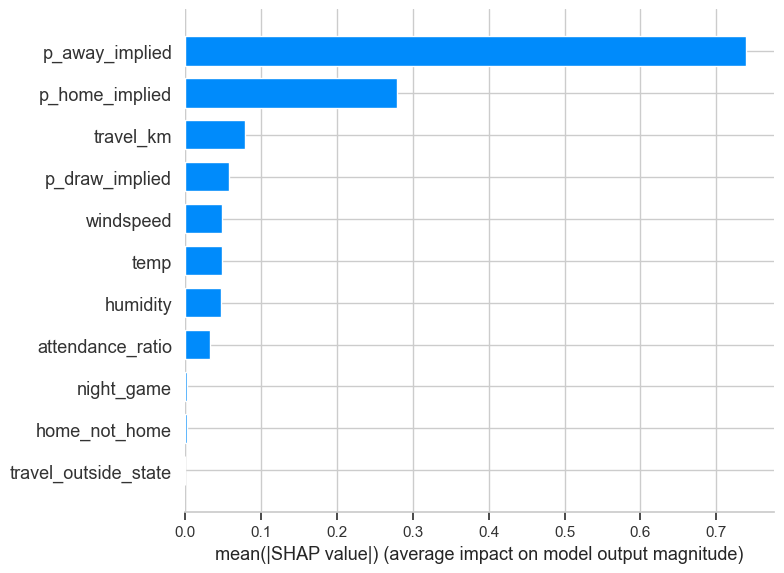

In [11]:
explainer = shap.TreeExplainer(gb_clf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")


Accuracy: 0.7450980392156863


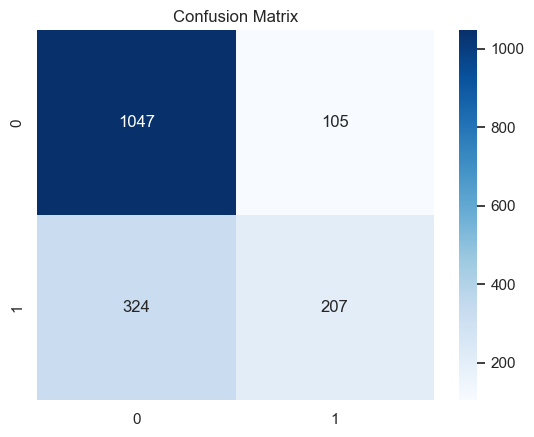

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score

pred_labels = gb_clf.predict(X_test)
cm = confusion_matrix(y_test, pred_labels)
acc = accuracy_score(y_test, pred_labels)

print("Accuracy:", acc)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


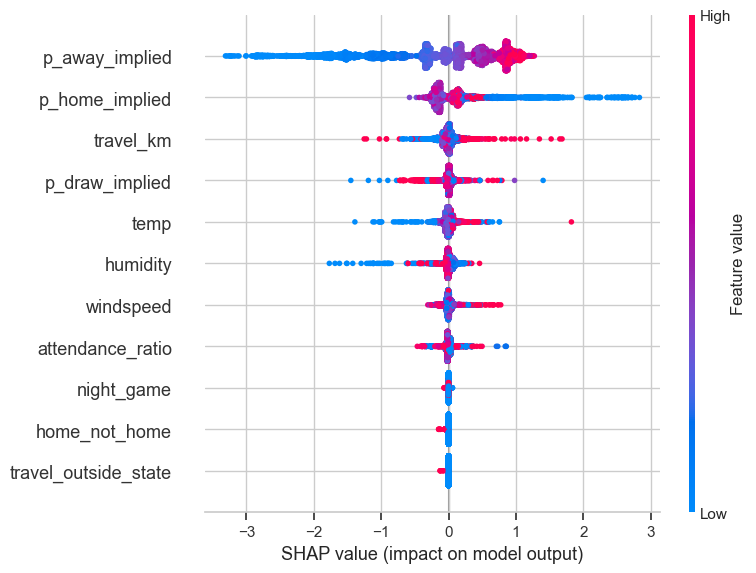

In [14]:
explainer = shap.TreeExplainer(gb_clf)

# compute SHAP values on the full training matrix
shap_values = explainer.shap_values(X_train)

# summary plot (full)
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)
